# Descifrando el rendimiento académico: Análisis mediante aprendizaje automático

## Introducción

## Carga de datos

In [1]:
import pandas as pd
# Cargamos el dataset
datos_estudiantes = pd.read_csv("Datasets/Exam_Score_Prediction.csv", sep=',', index_col="student_id")
datos_estudiantes.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
student_id,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


## Funciones

In [15]:
import tensorflow as tf

def preprocesamiento_calificaciones(datos_estudiantes):
    if datos_estudiantes['mark']=='failed':
        m=0
    elif datos_estudiantes['mark']=='passed':
        m=1
    elif datos_estudiantes['mark']=='good':
        m=2
    elif datos_estudiantes['mark']=='merit':
        m=3
    else:
        m=4
    datos_estudiantes['mark']=m
    return datos_estudiantes

def calculo_calificacion_estudiante(estudiante):
    if (estudiante.loc['exam_score']<50.00):
        return 'failed'
    elif (estudiante.loc['exam_score']<60.00):
        return 'passed'
    elif (estudiante.loc['exam_score']<70.00):
        return 'good'
    elif (estudiante.loc['exam_score']<90.00):
        return 'merit'
    else:
        return 'Excellent'

def compila_modelo(modelo, optimizer, lr=1e-3):
    opt = optimizer(learning_rate=lr)
    modelo.compile(
        optimizer=opt,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError,
        ]
    )
    return modelo

def entrena_y_evalua(modelo, X_train, y_train, X_val, y_val, X_test, y_test,
                     epochs=80, batch_size=256, callbacks=None, verbose=0):
    history = modelo.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks or [],
        verbose=verbose
    )

    # Evaluación final en test
    _, test_rmse = modelo.evaluate(X_test, y_test, verbose=0)

    return history, test_rmse

def plot_history(history, titulo="Entrenamiento"):
    h = history.history
    epochs = np.arange(1, len(h["loss"]) + 1)

    # Loss
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h["loss"], "--", linewidth=2, label="loss train")
    plt.plot(epochs, h["val_loss"], "-", linewidth=2, label="loss val")
    plt.title(titulo + " | Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h["root_mean_squared_error"], "--", linewidth=2, label="RMSE train")
    plt.plot(epochs, h["val_root_mean_squared_error"], "-", linewidth=2, label="RMSE val")
    plt.title(titulo + " | RMSE")
    plt.xlabel("Época")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

def plot_pred(y_real, y_pred):
    errores = np.abs(y_real - y_pred)

    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    sc = ax1.scatter(y_real, y_pred, c=errores, cmap='Reds', s=100, edgecolors='k')
    ax1.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Predicción Perfecta')

    ax1.set_title('Precisión General del Modelo', fontsize=14)
    ax1.set_xlabel('Nota Real', fontsize=12)
    ax1.set_ylabel('Nota Predicha', fontsize=12)
    ax1.set_xlim(0, 105)
    ax1.set_ylim(0, 105)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    cbar = plt.colorbar(sc, ax=ax1)
    cbar.set_label('Magnitud del Error')

    plt.show()

## Preparado de los datos

In [16]:
#Creamos un atributo para saber si han aprobado
datos_estudiantes['passed']=datos_estudiantes['exam_score']>=50.00

datos_estudiantes['mark']=datos_estudiantes.apply(lambda datos_estudiantes:calculo_calificacion_estudiante(datos_estudiantes), axis=1)

datos_estudiantes = datos_estudiantes.apply(preprocesamiento_calificaciones, axis=1)

datos_estudiantes.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,1,6,2.78,92.9,1,7.4,2,0,1,1,58.9,True,1
2,23,2,5,3.37,64.8,1,4.6,0,3,2,2,54.8,True,1
3,22,1,1,7.88,76.8,1,8.5,2,0,0,2,90.3,True,4
4,20,2,6,0.67,48.4,1,5.8,0,3,1,2,29.7,False,0
5,20,0,6,0.89,71.6,1,9.8,2,0,1,2,43.7,False,0


In [17]:
from sklearn.preprocessing import LabelEncoder

gender_encoder = LabelEncoder()
gender_encoder.fit(datos_estudiantes['gender'])
datos_estudiantes['gender'] = gender_encoder.transform(datos_estudiantes['gender'])
print("Codificamos el género")
print(list(gender_encoder.classes_))
print(gender_encoder.transform(gender_encoder.classes_))

course_encoder = LabelEncoder()
course_encoder.fit(datos_estudiantes['course'])
datos_estudiantes['course'] = course_encoder.transform(datos_estudiantes['course'])
print("\nCourse codification")
print(list(course_encoder.classes_))
print(course_encoder.transform(course_encoder.classes_))

internet_access_encoder = LabelEncoder()
internet_access_encoder.fit(datos_estudiantes['internet_access'])
datos_estudiantes['internet_access'] = internet_access_encoder.transform(datos_estudiantes['internet_access'])
print("\nCourse codification")
print(list(internet_access_encoder.classes_))
print(internet_access_encoder.transform(internet_access_encoder.classes_))

sleep_quality_encoder = LabelEncoder()
sleep_quality_encoder.fit(datos_estudiantes['sleep_quality'])
datos_estudiantes['sleep_quality'] = sleep_quality_encoder.transform(datos_estudiantes['sleep_quality'])
print("\nSleep Quality codification")
print(list(sleep_quality_encoder.classes_))
print(sleep_quality_encoder.transform(sleep_quality_encoder.classes_))

study_method_encoder = LabelEncoder()
study_method_encoder.fit(datos_estudiantes['study_method'])
datos_estudiantes['study_method'] = study_method_encoder.transform(datos_estudiantes['study_method'])
print("\nStudy Method codification")
print(list(study_method_encoder.classes_))
print(study_method_encoder.transform(study_method_encoder.classes_))

facility_rating_encoder = LabelEncoder()
facility_rating_encoder.fit(datos_estudiantes['facility_rating'])
datos_estudiantes['facility_rating'] = facility_rating_encoder.transform(datos_estudiantes['facility_rating'])
print("\nFacility Rating codification")
print(list(facility_rating_encoder.classes_))
print(facility_rating_encoder.transform(facility_rating_encoder.classes_))

exam_difficulty_encoder = LabelEncoder()
exam_difficulty_encoder.fit(datos_estudiantes['exam_difficulty'])
datos_estudiantes['exam_difficulty'] = exam_difficulty_encoder.transform(datos_estudiantes['exam_difficulty'])
print("\nExam Difficulty codification")
print(list(exam_difficulty_encoder.classes_))
print(exam_difficulty_encoder.transform(exam_difficulty_encoder.classes_))

passed_encoder = LabelEncoder()
passed_encoder.fit(datos_estudiantes['passed'])
datos_estudiantes['passed'] = passed_encoder.transform(datos_estudiantes['passed'])
print("\nExam Difficulty codification")
print(list(passed_encoder.classes_))
print(passed_encoder.transform(passed_encoder.classes_))

datos_estudiantes.head()

Codificamos el género
[np.int64(0), np.int64(1), np.int64(2)]
[0 1 2]

Course codification
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
[0 1 2 3 4 5 6]

Course codification
[np.int64(0), np.int64(1)]
[0 1]

Sleep Quality codification
[np.int64(0), np.int64(1), np.int64(2)]
[0 1 2]

Study Method codification
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
[0 1 2 3 4]

Facility Rating codification
[np.int64(0), np.int64(1), np.int64(2)]
[0 1 2]

Exam Difficulty codification
[np.int64(0), np.int64(1), np.int64(2)]
[0 1 2]

Exam Difficulty codification
[np.False_, np.True_]
[0 1]


,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,1,6,2.78,92.9,1,7.4,2,0,1,1,58.9,1,1
2,23,2,5,3.37,64.8,1,4.6,0,3,2,2,54.8,1,1
3,22,1,1,7.88,76.8,1,8.5,2,0,0,2,90.3,1,4
4,20,2,6,0.67,48.4,1,5.8,0,3,1,2,29.7,0,0
5,20,0,6,0.89,71.6,1,9.8,2,0,1,2,43.7,0,0


## Visualizacion previa

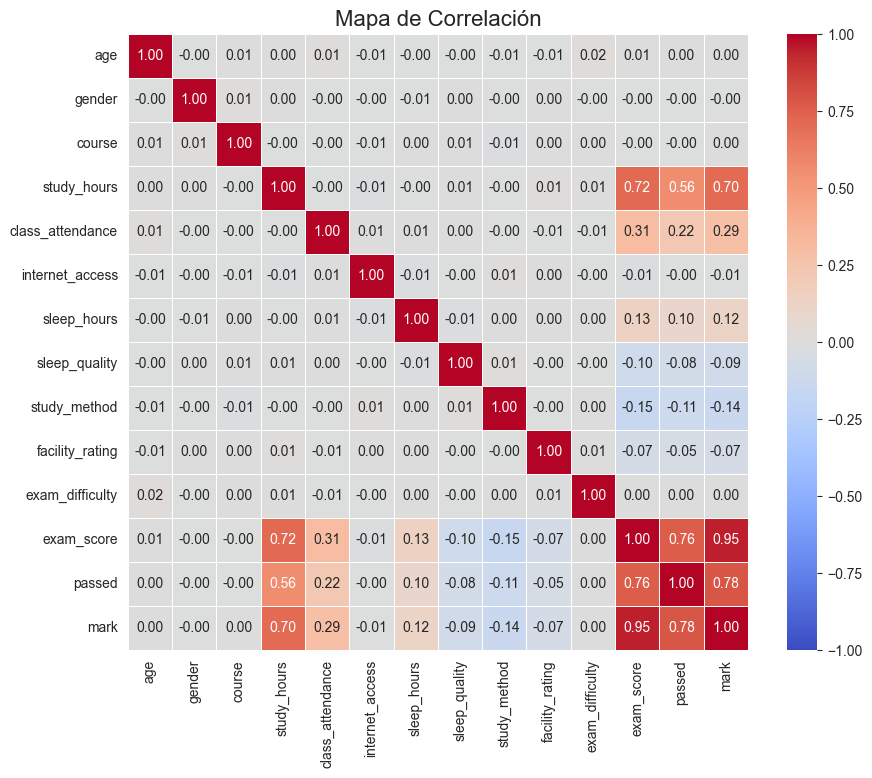

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

matriz_correlacion = datos_estudiantes.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Mapa de Correlación', fontsize=16)
plt.show()

## Regresión

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler().set_output(transform="pandas")
y_scaler = MinMaxScaler().set_output(transform="pandas")

X = datos_estudiantes.drop(['exam_score', 'passed', 'mark'], axis=1)
y = datos_estudiantes['exam_score']

X_scaled, y_scaled = X_scaler.fit_transform(X), y_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

### Metodos clasicos

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10]}
grid_lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)

#Resultados del mejor modelo
best_alpha = grid_lasso.best_params_['alpha']
best_model = grid_lasso.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Mejor Alpha: {best_alpha}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R2 Final: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE Final: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
coefs = pd.Series(best_model.coef_, index=X_train.columns)
print(f"Variables mantenidas: {len(coefs[coefs != 0])}")

Mejor Alpha: 0.0001
MSE: 0.0181
R2 Final: 0.6739
RMSE Final: 0.1345
Variables mantenidas: 10


### Redes neuronales

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler().set_output(transform="pandas")
y_scaler = MinMaxScaler().set_output(transform="pandas")

X = datos_estudiantes.drop(['exam_score', 'passed', 'mark'], axis=1)
y = datos_estudiantes['exam_score']

X_scaled, y_scaled = X_scaler.fit_transform(X), y_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [ ]:
def compila_modelo(modelo, optimizer, lr=1e-3):
    opt = optimizer(learning_rate=lr)
    modelo.compile(
        optimizer=opt,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError,
        ]
    )
    return modelo

def entrena_y_evalua(modelo, X_train, y_train, X_val, y_val, X_test, y_test,
                     epochs=80, batch_size=256, callbacks=None, verbose=0):
    history = modelo.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks or [],
        verbose=verbose
    )

    # Evaluación final en test
    _, test_rmse = modelo.evaluate(X_test, y_test, verbose=0)

    return history, test_rmse

def plot_history(history, titulo="Entrenamiento"):
    h = history.history
    epochs = np.arange(1, len(h["loss"]) + 1)

    # Loss
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h["loss"], "--", linewidth=2, label="loss train")
    plt.plot(epochs, h["val_loss"], "-", linewidth=2, label="loss val")
    plt.title(titulo + " | Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h["root_mean_squared_error"], "--", linewidth=2, label="RMSE train")
    plt.plot(epochs, h["val_root_mean_squared_error"], "-", linewidth=2, label="RMSE val")
    plt.title(titulo + " | RMSE")
    plt.xlabel("Época")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

def plot_pred(y_real, y_pred):
    errores = np.abs(y_real - y_pred)

    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    sc = ax1.scatter(y_real, y_pred, c=errores, cmap='Reds', s=100, edgecolors='k')
    ax1.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Predicción Perfecta')

    ax1.set_title('Precisión General del Modelo', fontsize=14)
    ax1.set_xlabel('Nota Real', fontsize=12)
    ax1.set_ylabel('Nota Predicha', fontsize=12)
    ax1.set_xlim(0, 105)
    ax1.set_ylim(0, 105)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    cbar = plt.colorbar(sc, ax=ax1)
    cbar.set_label('Magnitud del Error')

    plt.show()

### Modelo A

In [ ]:
def build_model_A(input_dim):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation="relu")(entrada)
    x = tf.keras.layers.Dense(30, activation="relu")(x)
    salida = tf.keras.layers.Dense(1, activation="relu")(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

In [ ]:
modeloA = build_model_A(X_train.shape[1])
modeloA = compila_modelo(modeloA, tf.keras.optimizers.Adam, lr=1e-3)

histA, rmseA = entrena_y_evalua(
    modeloA, X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=80, batch_size=256, verbose=1
)

Epoch 1/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0559 - root_mean_squared_error: 0.2365 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1765
Epoch 2/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1550
Epoch 3/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1473
Epoch 4/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1432
Epoch 5/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1399
Epoch 6/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 7/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184

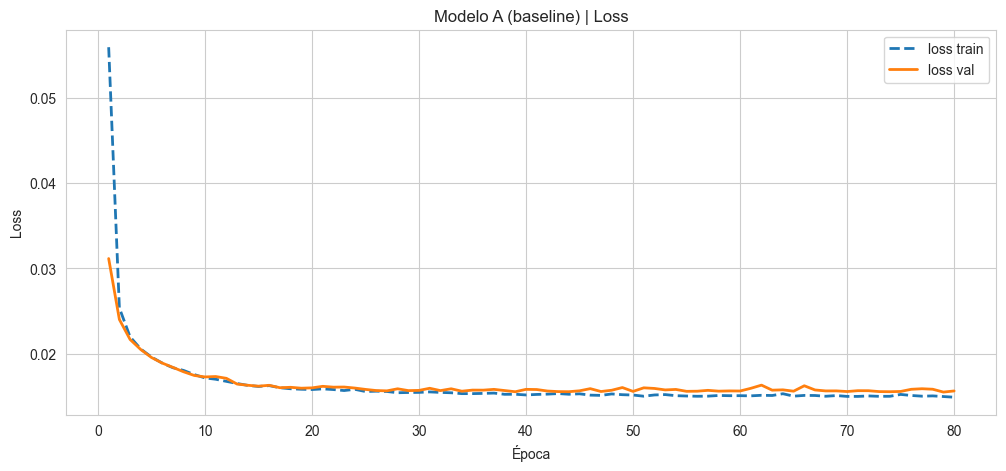

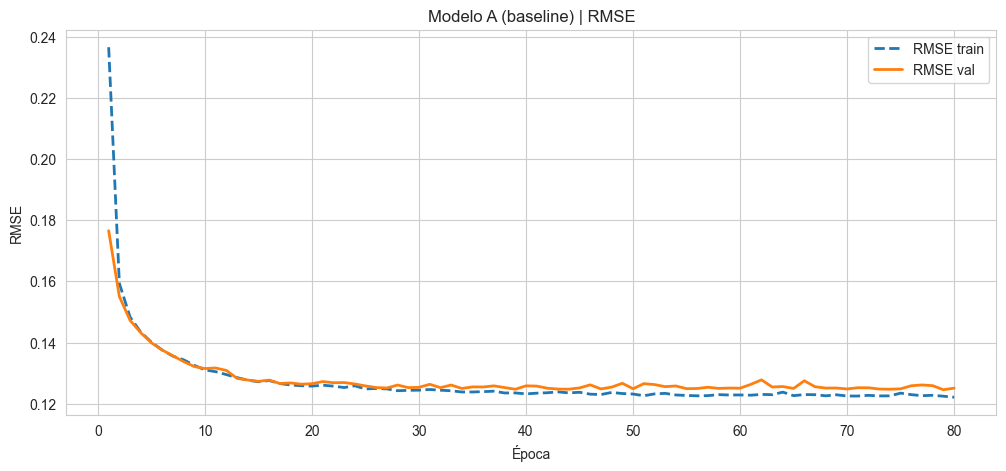

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


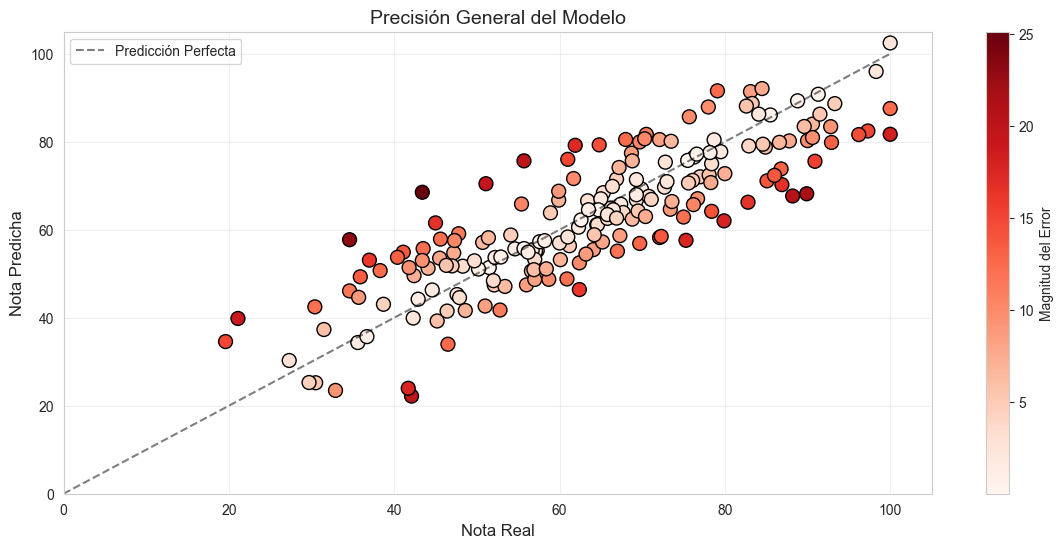

In [ ]:
plot_history(histA, "Modelo A (baseline)")
y_pred = modeloA.predict(X_test[:200])
y_pred_inv = y_scaler.inverse_transform(y_pred)
y_test_inv = y_scaler.inverse_transform(y_test[:200])
plot_pred(y_test_inv, y_pred_inv)

### Modelo B

In [ ]:
def build_model_B(input_dim):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation="relu")(entrada)
    x = tf.keras.layers.Dense(30, activation="relu")(x)
    salida = tf.keras.layers.Dense(1, activation="relu")(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

In [ ]:
modeloB = build_model_B(X_train.shape[1])
modeloB = compila_modelo(modeloB, tf.keras.optimizers.Adam, lr=1e-3)

histB, rmseB = entrena_y_evalua(
    modeloB, X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=80, batch_size=256, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0369 - root_mean_squared_error: 0.1921 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1483
Epoch 2/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - root_mean_squared_error: 0.1424 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1404
Epoch 3/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367
Epoch 4/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - root_mean_squared_error: 0.1332 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1340
Epoch 5/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1323
Epoch 6/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1311
Epoch 7/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167

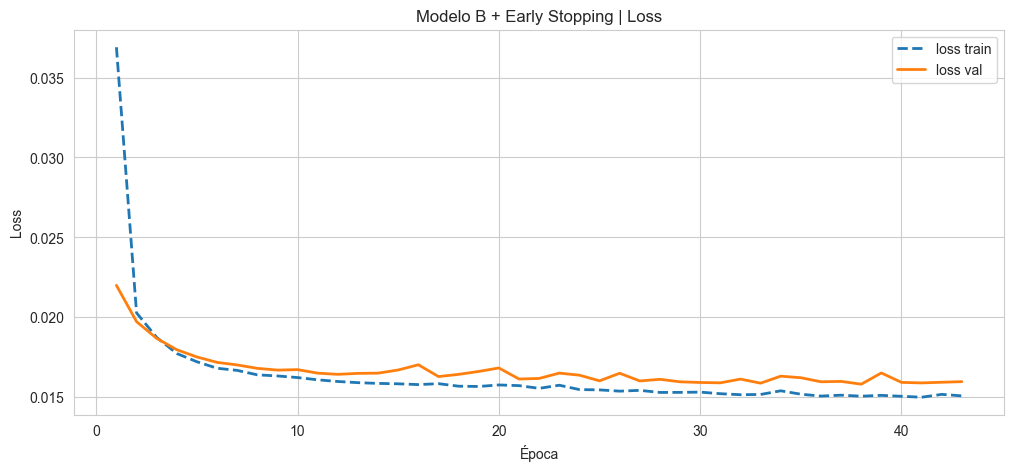

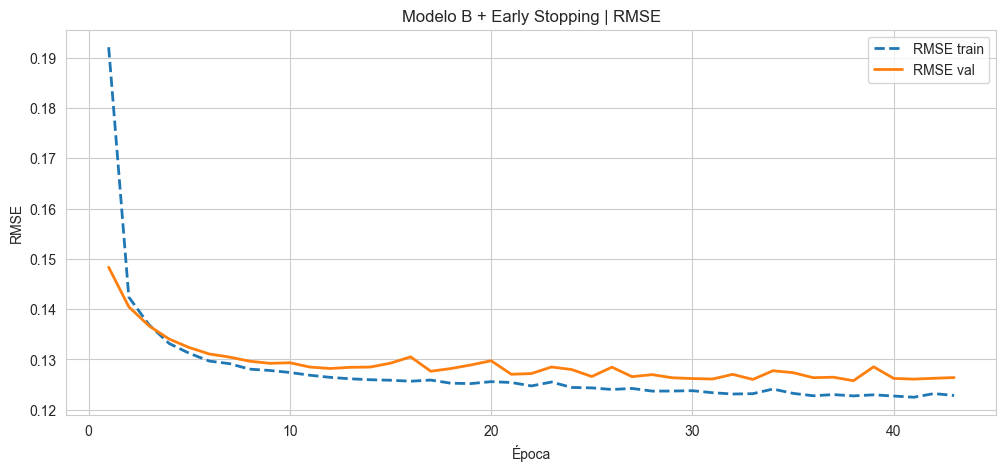

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


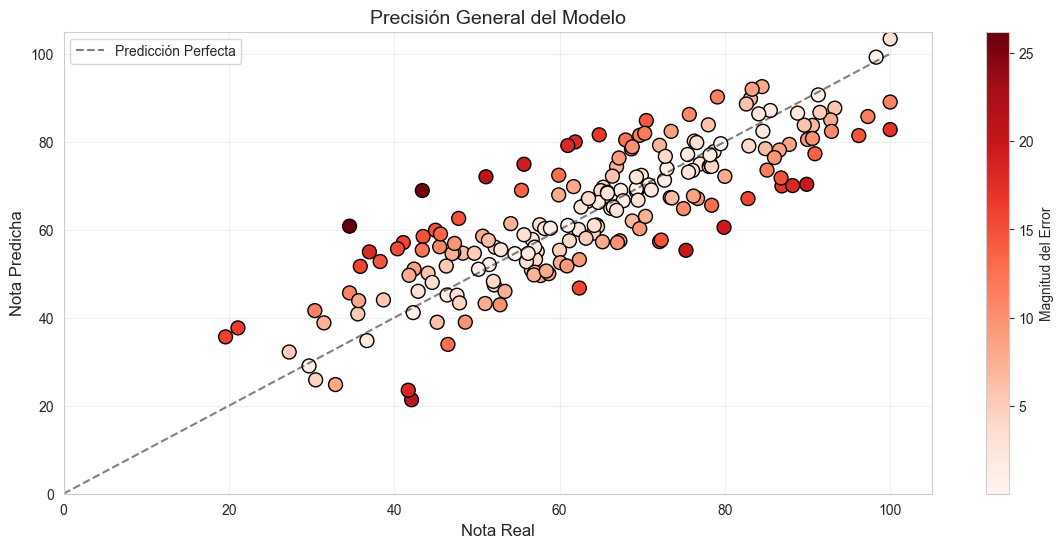

In [ ]:
plot_history(histB, "Modelo B + Early Stopping")
y_pred = modeloB.predict(X_test[:200])
y_pred_inv = y_scaler.inverse_transform(y_pred)
y_test_inv = y_scaler.inverse_transform(y_test[:200])
plot_pred(y_test_inv, y_pred_inv)

### Grid Search

In [ ]:
def build_model(input_dim, layer1, layer2, layer3=0, dropout=0):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(layer1, activation="relu")(entrada)
    x = tf.keras.layers.Dense(layer2, activation="relu")(x)

    if layer3 > 0:
        x = tf.keras.layers.Dense(layer3, activation="relu")(x)

    dropout = tf.keras.layers.Dropout(dropout)(x)
    salida = tf.keras.layers.Dense(1, activation="relu")(dropout)
    return tf.keras.Model(inputs=entrada, outputs=salida)

In [ ]:
import itertools

grid_neuronas = list(itertools.combinations([8, 16, 32, 64], 3))
grid_lr = [1e-2, 1e-3, 1e-4]
grid_dropout = [0.1, 0.2, 0.3]
grid_opts = [tf.keras.optimizers.Adam, tf.keras.optimizers.AdamW, tf.keras.optimizers.SGD]

grid_comb = list(itertools.product(grid_neuronas, grid_lr, grid_dropout, grid_opts))

resultados = []

best_rmse = float('inf')
best_model = None
best_params = {}

print(f"Iniciando Grid Search ({len(grid_comb)} combinaciones)...")

for (layer1, layer2, layer3), lr, dropout, opt in grid_comb:
    print(f"\nProbando: Neuronas={[layer1, layer2, layer3]}, LR={lr},OPT={opt}, Dropout={dropout}")

    modelo_temp = build_model(X_train.shape[1], layer1, layer2, layer3, dropout)

    modelo_temp = compila_modelo(modelo_temp, opt, lr=lr)

    hist, rmse_test = entrena_y_evalua(
        modelo_temp, X_train, y_train, X_val, y_val, X_test, y_test,
        epochs=100,
        batch_size=256,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )

    print(f"  -> Resultado RMSE Test: {rmse_test:.4f}")

    resultados.append({
        'neuronas': (layer1, layer2, layer3),
        'dropout': dropout,
        'lr': lr,
        'rmse': rmse_test
    })

    if rmse_test < best_rmse:
        best_rmse = rmse_test
        best_model = modelo_temp
        best_params = {'neuronas': (layer1, layer2, layer3), 'lr': lr, 'dropout': dropout, 'rmse': rmse_test}

print(f"MEJOR RESULTADO: RMSE = {best_rmse:.4f}")
print(f"MEJORES PARÁMETROS: {best_params}")

df_resultados = pd.DataFrame(resultados).sort_values(by='rmse')
print(df_resultados)

Iniciando Grid Search (108 combinaciones)...

Probando: Neuronas=[8, 16, 32], LR=0.01,OPT=<class 'keras.src.optimizers.adam.Adam'>, Dropout=0.1
  -> Resultado RMSE Test: 0.1284

Probando: Neuronas=[8, 16, 32], LR=0.01,OPT=<class 'keras.src.optimizers.adamw.AdamW'>, Dropout=0.1
  -> Resultado RMSE Test: 0.1238

Probando: Neuronas=[8, 16, 32], LR=0.01,OPT=<class 'keras.src.optimizers.sgd.SGD'>, Dropout=0.1
  -> Resultado RMSE Test: 0.1373

Probando: Neuronas=[8, 16, 32], LR=0.01,OPT=<class 'keras.src.optimizers.adam.Adam'>, Dropout=0.2
  -> Resultado RMSE Test: 0.1291

Probando: Neuronas=[8, 16, 32], LR=0.01,OPT=<class 'keras.src.optimizers.adamw.AdamW'>, Dropout=0.2
  -> Resultado RMSE Test: 0.1308

Probando: Neuronas=[8, 16, 32], LR=0.01,OPT=<class 'keras.src.optimizers.sgd.SGD'>, Dropout=0.2
  -> Resultado RMSE Test: 0.1513

Probando: Neuronas=[8, 16, 32], LR=0.01,OPT=<class 'keras.src.optimizers.adam.Adam'>, Dropout=0.3
  -> Resultado RMSE Test: 0.1241

Probando: Neuronas=[8, 16, 32]

In [ ]:
df_resultados.to_csv("res.csv")

## Clasificación

### Metodos clasicos

## 1. Carga de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

np.random.seed(42)

df = pd.read_csv("Datasets/Exam_Score_Prediction.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


### Justificación del Análisis Exploratorio

Analizando `info()` se observan muchas variables categóricas como `gender`, `course`, `sleep_quality`, etc. A estas variables se les realiza un preprocesamiento. 
La variable objetivo es `exam_score`.

## 2. Conjunto de Pruebas

Si hacemos un muestreo aleatorio, puede que el conjunto de pruebas no representa la población original. Para evitar este problemas se revisa la distribución de notas.

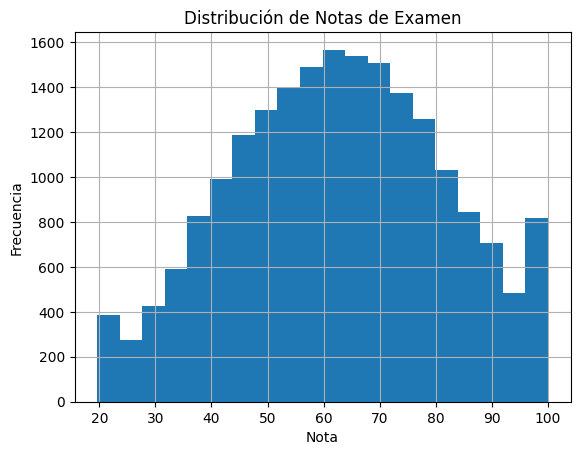

In [ ]:
df['exam_score'].hist(bins=20)
plt.title("Distribución de Notas de Examen")
plt.xlabel("Nota")
plt.ylabel("Frecuencia")
plt.show()

Además de la nota, es crucial que el test set tenga una proporción representativa de `gender` y `course`, ya que intuitivamente podrían influir en el resultado y queremos evitar sesgos.

Vamos a usar `StratifiedShuffleSplit` basándonos en una variable categórica "nota_cat" que crearemos para garantizar que haya alumnos de todos los niveles en ambos conjuntos.

In [ ]:
df['score_cat'] = pd.cut(df['exam_score'], 
                         bins=[0, 50, 60, 70, 80, 100], 
                         labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["score_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("score_cat", axis=1, inplace=True)

students = strat_train_set.drop("exam_score", axis=1)
students_labels = strat_train_set["exam_score"].copy()
    
print(f"Tamaño conjunto de entrenamiento: {len(strat_train_set)}")
print(f"Tamaño conjunto de pruebas: {len(strat_test_set)}")

Tamaño conjunto de entrenamiento: 16000
Tamaño conjunto de pruebas: 4000


## 3. Preparación de los Datos y Pipeline

El dataset contiene una mezcla de variables numéricas y categóricas necesitan procesarse para poder trabajar con ellas.

**Decisiones de Preprocesamiento:**
1. **Escalado**: `StandardScaler` para algoritmos como SGD y SVM.
2. **Variables Categóricas**:
    - **Ordinales** (`sleep_quality`, `facility_rating`, `exam_difficulty`): Tienen un orden lógico (Malo < Medio < Bueno), por lo que usamos `OrdinalEncoder`.
    - **Nominales** (`gender`, `course`, `study_method`, `internet_access`): No tienen orden intrínseco, usaremos `OneHotEncoder`.

In [ ]:
num_attribs = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
ord_attribs = ['sleep_quality', 'facility_rating', 'exam_difficulty']
cat_attribs = ['gender', 'course', 'study_method', 'internet_access']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

ordinal_categories = [
    ['poor', 'average', 'good'],      # sleep_quality
    ['low', 'medium', 'high'],        # facility_rating
    ['easy', 'moderate', 'hard']      # exam_difficulty
]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("ord", OrdinalEncoder(categories=ordinal_categories), ord_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

students_prepared = full_pipeline.fit_transform(students)
print(f"Dimensiones de los datos procesados: {students_prepared.shape}")

Dimensiones de los datos procesados: (16000, 24)


## 3.1. Clasificador Binario

El problema se puede simplificar en si el alumno aprobará o no, por lo que trabajaremos con el umbral de 50 puntos para el aprobado.

In [ ]:
y_train_pass = (students_labels >= 50)
y_train_pass.value_counts()

exam_score
True     11676
False     4324
Name: count, dtype: int64

Utilizaremos `SGDClassifier` (Stochastic Gradient Descent). Es eficiente y funciona bien como clasificador lineal base. Además, nos permitirá obtener puntuaciones de decisión para las curvas de precisión-cobertura más adelante.

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(students_prepared, y_train_pass)

print("Predicción para el primer alumno:", sgd_clf.predict([students_prepared[0]]))

Predicción para el primer alumno: [False]


### Validación Cruzada

In [ ]:
cv_scores = cross_val_score(sgd_clf, students_prepared, y_train_pass, cv=3, scoring="accuracy")
print("Precisión:", cv_scores.mean())
cv_scores = cross_val_score(sgd_clf, students_prepared, y_train_pass, cv=3, scoring="recall")
print("Cobertura:", cv_scores.mean())

Precisión: 0.8578746473491864
Cobertura: 0.9228331620417952


## 4. Matriz de Confusión

Matriz de Confusión:
 [[ 2951  1373]
 [  901 10775]]


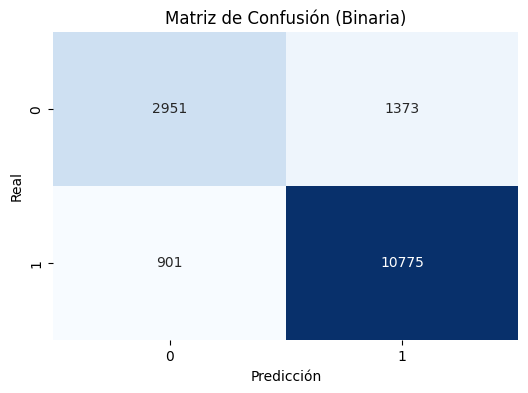

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, students_prepared, y_train_pass, cv=3)

cm = confusion_matrix(y_train_pass, y_train_pred)
print("Matriz de Confusión:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Binaria)')
plt.show()

Métricas derivadas de la matriz de confusión:
- **Precisión**: De los que dijimos que aprobarían, ¿cuántos aprobaron realmente?
- **Cobertura**: De los que realmente aprobaron, ¿cuántos detectamos?
- **F1**: Media armónica entre ambas.

In [ ]:
print("Precision:", precision_score(y_train_pass, y_train_pred))
print("Recall:", recall_score(y_train_pass, y_train_pred))
print("F1 Score:", f1_score(y_train_pass, y_train_pred))

Precision: 0.8869772802107343
Recall: 0.9228331620417951
F1 Score: 0.9045500335795836


## 5. Curvas de Precisión-Cobertura

Graficaremos cómo varían Precision y Recall para todos los umbrales posibles.

Ejemplos de scores: [-2.30354476  5.08591833  2.54126045  3.49965255  1.80959591]


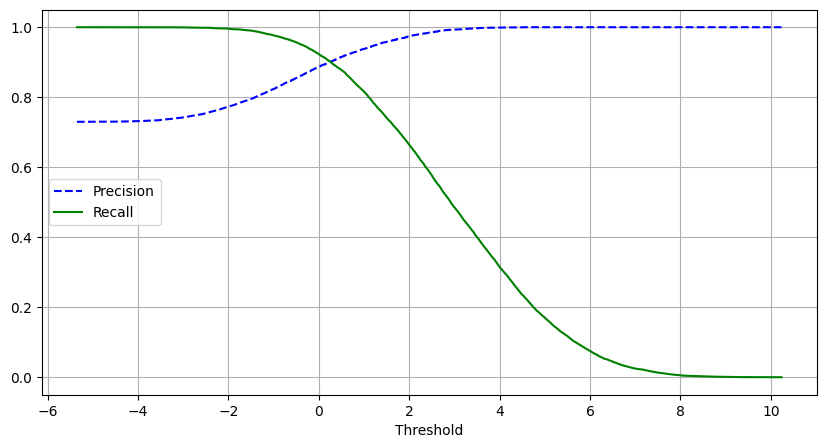

In [ ]:
y_scores = cross_val_predict(sgd_clf, students_prepared, y_train_pass, cv=3, method="decision_function")

print("Ejemplos de scores:", y_scores[:5])

precisions, recalls, thresholds = precision_recall_curve(y_train_pass, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.grid(True)

plt.figure(figsize=(10, 5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## 6. Umbral Óptimo y Curva PR

Podemos buscar el umbral que nos da un 90% de precisión o el que maximiza el F1 score.

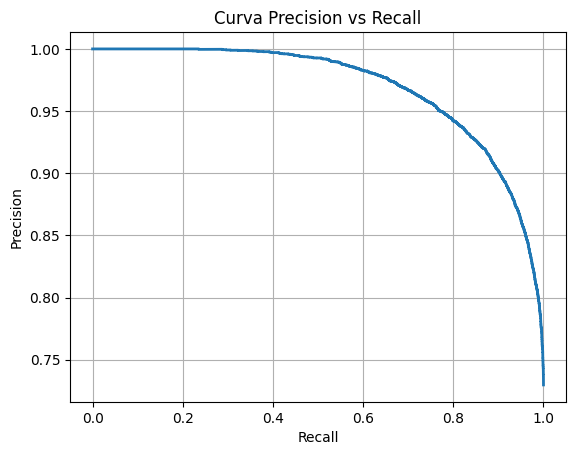

In [ ]:
plt.plot(recalls, precisions, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision vs Recall")
plt.grid(True)
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(f"Umbral para 90% precision: {threshold_90_precision}")

y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precision obtenida:", precision_score(y_train_pass, y_train_pred_90))
print("Recall obtenido:", recall_score(y_train_pass, y_train_pred_90))

Umbral para 90% precision: 0.23666844060521686
Precision obtenida: 0.9000085389804457
Recall obtenido: 0.9027064063035286


## 7. Curva ROC

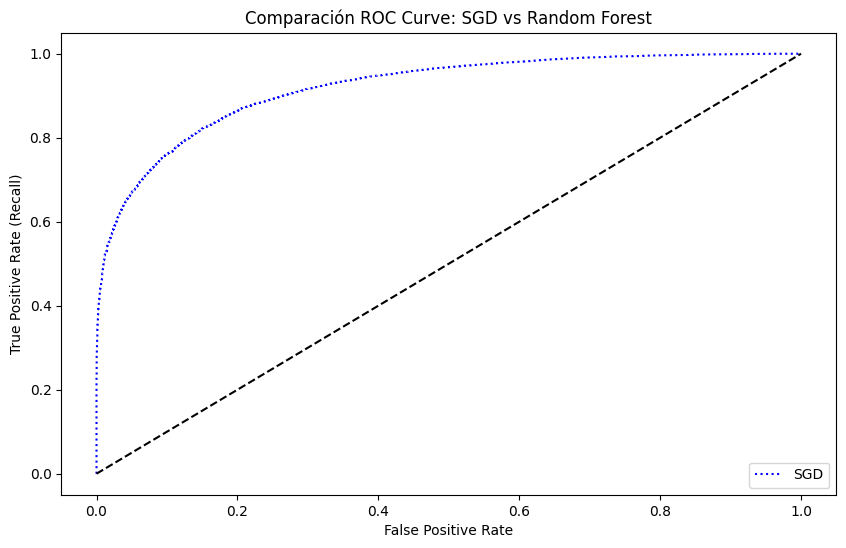

AUC SGD: 0.9195030192312383


In [ ]:
# SGD ROC
fpr, tpr, thresholds_roc = roc_curve(y_train_pass, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc="lower right")
plt.title("Curva ROC")
plt.show()

print("AUC SGD:", roc_auc_score(y_train_pass, y_scores))

### Redes Neuronales

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().set_output(transform="pandas")
datos_estudiantes_scaled = scaler.fit_transform(datos_estudiantes)
datos_estudiantes_scaled.head()

# y_raw = datos_estudiantes['mark']   # NO scaled
# si mark está como texto: failed/passed/...
# usa LabelEncoder (esto da 0..4)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(datos_estudiantes['mark'])

# split estratificado
from sklearn.model_selection import train_test_split
X = datos_estudiantes_scaled.drop(['exam_score','passed','mark'], axis=1)  # X sí escalado
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

#Se le da un peso diferente a las clases. Así, si una clase tiene menos ejemplos, se le da más peso para evitar el desbalance. A una clase con más ejemplos, se le da un menor peso.
class_weights_arr = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("class_weights:", class_weights)


In [ ]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)


y_raw = datos_estudiantes['mark'].copy()


mapa_mark = {'failed': 0, 'passed': 1, 'good': 2, 'merit': 3, 'excellent': 4}
if y_raw.dtype == object:
    y = y_raw.map(mapa_mark).astype(int).to_numpy()
else:
    y = y_raw.astype(int).to_numpy()

class_names = ['failed', 'passed', 'good', 'merit', 'excellent']
num_classes = 5

# Split estratificado: train/val/test
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.75, random_state=42, stratify=y
)


classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

print('Distribución train:', dict(zip(*np.unique(y_train, return_counts=True))))
print('class_weights:', class_weights)


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, titulo):
    h = history.history
    epochs = np.arange(1, len(h['loss']) + 1)

    # Loss
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['loss'], '--', linewidth=2, label='loss train')
    plt.plot(epochs, h['val_loss'], '-', linewidth=2, label='loss val')
    plt.title(titulo + ' | Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['accuracy'], '--', linewidth=2, label='acc train')
    plt.plot(epochs, h['val_accuracy'], '-', linewidth=2, label='acc val')
    plt.title(titulo + ' | Accuracy')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evalua_clasificacion(modelo, X_test, y_test):
    probs = modelo.predict(X_test, verbose=0) #toma las probabilidades por clase
    y_pred = np.argmax(probs, axis=1)#toma la clase con mayor probabilidad

    #Mostramos la matriz de confusión
    print('Confusion matrix (test):')
    print(confusion_matrix(y_test, y_pred))

    #Mostramos precision, recall
    print('\nClassification report (test):')
    # target_names tiene que ser lista de strings
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


In [ ]:
#Para ir mejorando el entrenamiento sin cambios bruscos
cb_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

cb_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)


In [ ]:
def build_model_A(input_dim, num_classes):
    #La entrada tiene como tamaño el número de columnas de x
    #Tiene dos capas densas de 30 neuronas con función de activación ReLU
    #La capa de salida tiene 5 neuronas con función de activación softmax
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation='relu')(entrada)
    x = tf.keras.layers.Dense(30, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloA = build_model_A(X_train.shape[1], num_classes)
modeloA.compile(
    #Optimizador Adam
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    #SparseCategorical se usa cuando son enteros
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    #la accuracy cuando la clase son números enteros
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyA = modeloA.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    verbose=1
)

plot_history(historyA, 'Modelo A (baseline)')
evalua_clasificacion(modeloA, X_test, y_test)


In [ ]:
modeloB = build_model_A(X_train.shape[1], num_classes)
modeloB.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyB = modeloB.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=256,
    callbacks=[cb_early],
    verbose=1
)

plot_history(historyB, 'Modelo B (+EarlyStopping)')
evalua_clasificacion(modeloB, X_test, y_test)

#Al añadir el número de épocas y el earlyStopping, mejoramos en un 1%


In [ ]:
#Añadimos dropout
def build_model_C(input_dim, num_classes, dropout=0.25):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(entrada)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloC = build_model_C(X_train.shape[1], num_classes, dropout=0.25)
modeloC.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyC = modeloC.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=256,
    callbacks=[cb_early],
    verbose=1
)

plot_history(historyC, 'Modelo C (+Dropout)')
evalua_clasificacion(modeloC, X_test, y_test)

#Empeoramos --> accuracy 56


Probamos con más capas

In [ ]:
import tensorflow as tf

def build_model_DEEP_NO_DROPOUT_NO_BN_NO_L2(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    
    x = tf.keras.layers.Dense(256, activation='relu')(entrada)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloW = build_model_DEEP_NO_DROPOUT_NO_BN_NO_L2(X_train.shape[1], num_classes)

modeloW.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyW = modeloW.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyW, 'Modelo DEEP sin Dropout/BN/L2 (+ReduceLR + class_weight)')
evalua_clasificacion(modeloW, X_test, y_test)

#Mejora muy poco, así que vamos a probar con más neuronas del base

In [ ]:
import tensorflow as tf

def build_model_WIDE_NO_DROPOUT_NO_BN_NO_L2(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    # Misma profundidad (pocas capas), pero más neuronas por capa (más "ancho")
    x = tf.keras.layers.Dense(512, activation='relu')(entrada)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    # opcional: capa intermedia ancha antes de softmax
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloW = build_model_WIDE_NO_DROPOUT_NO_BN_NO_L2(X_train.shape[1], num_classes)

modeloW.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyW = modeloW.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyW, 'Modelo WIDE sin Dropout/BN/L2 (+ReduceLR + class_weight)')
evalua_clasificacion(modeloW, X_test, y_test)

#mejora muy poco a más capas, probamos a meter más capas y neuronas


In [ ]:
import tensorflow as tf

def build_model_DEEP_WIDE_NO_DROPOUT_NO_BN_NO_L2(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    # Más capas y más neuronas, sin Dropout, sin BatchNorm, sin L2
    x = tf.keras.layers.Dense(512, activation='relu')(entrada)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloW = build_model_DEEP_WIDE_NO_DROPOUT_NO_BN_NO_L2(X_train.shape[1], num_classes)

modeloW.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyW = modeloW.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyW, 'Modelo DEEP+WIDE sin Dropout/BN/L2 (+ReduceLR + class_weight)')
evalua_clasificacion(modeloW, X_test, y_test)

#vemos que empeora el resultado, probamos a añadir aun más neuronas


Muchas neuronas

In [ ]:
import tensorflow as tf

def build_model_DEEP_WIDE_MORE_NEURONS_NO_DROPOUT_NO_BN_NO_L2(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    # MISMAS capas que antes (6 densas antes de softmax), pero MÁS neuronas
    x = tf.keras.layers.Dense(1024, activation='relu')(entrada)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloW = build_model_DEEP_WIDE_MORE_NEURONS_NO_DROPOUT_NO_BN_NO_L2(X_train.shape[1], num_classes)

modeloW.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyW = modeloW.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyW, 'Modelo (mismas capas) con muchas más neuronas')
evalua_clasificacion(modeloW, X_test, y_test)


Despues de esto, nos queda probar con varias estructuras, optimizadores, dropouts y learning rates

In [ ]:
import time
import itertools
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Utilidades (igual idea que antes)
# -----------------------------
def evalua_clasificacion(modelo, X_test, y_test, class_names):
    probs = modelo.predict(X_test, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    print("Confusion matrix (test):")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

def build_mlp(input_dim, num_classes, hidden_units, dropout=0.0):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = entrada
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation="relu")(x)
        if dropout and dropout > 0:
            x = tf.keras.layers.Dropout(dropout)(x)
    salida = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

def make_optimizer(name, lr):
    name = name.lower()
    if name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    if name == "adamw":
        # si no está disponible en tu TF, cae a Adam
        try:
            return tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
        except Exception:
            return tf.keras.optimizers.Adam(learning_rate=lr)
    raise ValueError(f"Optimizador no soportado: {name}")

# -----------------------------
# GridSearch manual con SOLO EarlyStopping y límite de tiempo (<= 20 min)
# -----------------------------
def grid_search_mlp_timeboxed(
    X_train, y_train, X_val, y_val,
    input_dim, num_classes,
    class_weights=None,
    seed=42,
    time_budget_minutes=20,
    max_trials=10_000,       # además del tiempo, por si quieres capear por nº de pruebas
    max_epochs=120,          # para que no se alargue demasiado cada trial
    batch_size=256,
    patience=5,              # baja si quieres que corte antes
    monitor="val_loss"
):
    tf.keras.utils.set_random_seed(seed)

    # ÚNICO callback permitido: EarlyStopping
    cb_early = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=True
    )

    # Espacio de búsqueda (ajusta a tu gusto)
    grid_hidden_units = [
        [128, 128],
        [256, 256],
        [512, 256],
        [512, 512],
        [512, 512, 256],
        [1024, 512, 256],
    ]
    grid_dropouts = [0.0, 0.3]
    grid_optimizers = ["adam", "adamw", "sgd"]
    grid_lrs = [1e-3, 1e-4]

    combos = list(itertools.product(grid_hidden_units, grid_dropouts, grid_optimizers, grid_lrs))
    total_combos = len(combos)

    budget_secs = time_budget_minutes * 60
    t0 = time.time()

    results = []
    best_overall = None

    trial = 0
    for hidden_units, dropout, opt_name, lr in combos:
        # Corte por tiempo
        if (time.time() - t0) >= budget_secs:
            print(f"\n[STOP] Presupuesto de tiempo alcanzado (≈ {time_budget_minutes} min).")
            break

        # Corte por nº de pruebas
        if trial >= max_trials:
            print(f"\n[STOP] Límite de pruebas alcanzado (max_trials={max_trials}).")
            break

        trial += 1
        tf.keras.backend.clear_session()

        model = build_mlp(input_dim, num_classes, hidden_units, dropout=dropout)
        model.compile(
            optimizer=make_optimizer(opt_name, lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=[cb_early],            # SOLO EarlyStopping
            class_weight=class_weights,
            verbose=0
        )

        # Como restore_best_weights=True, el modelo acaba con los mejores pesos según monitor.
        # Para reportar "mejor epoch", lo inferimos del history:
        h = history.history
        if "val_loss" in h and len(h["val_loss"]) > 0:
            best_idx = int(np.argmin(h["val_loss"]))
            best_val_loss = float(h["val_loss"][best_idx])
            best_val_acc = float(h.get("val_accuracy", [np.nan]*len(h["val_loss"]))[best_idx])
            best_epoch = best_idx + 1
        else:
            best_val_loss = np.inf
            best_val_acc = np.nan
            best_epoch = None

        row = {
            "hidden_units": tuple(hidden_units),
            "dropout": float(dropout),
            "optimizer": opt_name,
            "lr": float(lr),
            "trained_epochs": len(h.get("loss", [])),
            "best_epoch": best_epoch,
            "best_val_loss": best_val_loss,
            "best_val_accuracy": best_val_acc,
            "best_weights": model.get_weights(),   # son los mejores por EarlyStopping
        }
        results.append(row)

        if (best_overall is None) or (best_val_loss < best_overall["best_val_loss"]):
            best_overall = row

        elapsed = time.time() - t0
        print(
            f"[{trial:>3}/{total_combos}] units={hidden_units}, drop={dropout}, opt={opt_name}, lr={lr} "
            f"-> best_val_loss={best_val_loss:.5f}, best_val_acc={best_val_acc:.5f}, "
            f"epochs={row['trained_epochs']} | elapsed={elapsed/60:.1f}m"
        )

    results_sorted = sorted(results, key=lambda d: d["best_val_loss"])
    return results_sorted, best_overall

# -----------------------------
# Ejecución + evaluación del mejor en TEST
# -----------------------------
# Asume que ya tienes: X_train, y_train, X_val, y_val, X_test, y_test, class_weights, class_names, num_classes

results_sorted, best = grid_search_mlp_timeboxed(
    X_train, y_train, X_val, y_val,
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    class_weights=class_weights,     # pon None si no quieres
    time_budget_minutes=20,          # <= 20 minutos
    max_epochs=120,                  # baja a 60-80 si va lento
    patience=8,                      # baja a 5 si quieres cortar antes
    batch_size=256
)

print("\nTOP 10 configs por val_loss (de lo que haya dado tiempo a probar):")
for i, r in enumerate(results_sorted[:10], start=1):
    print(
        f"{i:>2}. units={list(r['hidden_units'])} drop={r['dropout']} opt={r['optimizer']} lr={r['lr']} "
        f"| best_val_loss={r['best_val_loss']:.5f} best_val_acc={r['best_val_accuracy']:.5f} "
        f"best_epoch={r['best_epoch']} trained_epochs={r['trained_epochs']}"
    )

# Reconstruir el mejor y evaluar en TEST
tf.keras.backend.clear_session()
best_model = build_mlp(X_train.shape[1], num_classes, list(best["hidden_units"]), dropout=best["dropout"])
best_model.compile(
    optimizer=make_optimizer(best["optimizer"], best["lr"]),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)
best_model.set_weights(best["best_weights"])

print("\nMejor configuración final (según val_loss):")
print(best["hidden_units"], "drop=", best["dropout"], "opt=", best["optimizer"], "lr=", best["lr"])
evalua_clasificacion(best_model, X_test, y_test, class_names)


In [ ]:
import time, itertools, pickle
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Utilidades
# -----------------------------
def evalua_clasificacion(modelo, X_test, y_test, class_names):
    probs = modelo.predict(X_test, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    print("Confusion matrix (test):")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

def build_mlp(input_dim, num_classes, hidden_units, dropout=0.0):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = entrada
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation="relu")(x)
        if dropout and dropout > 0:
            x = tf.keras.layers.Dropout(dropout)(x)
    salida = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

def make_optimizer(name, lr):
    name = name.lower()
    if name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if name == "adamw":
        try:
            return tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
        except Exception:
            return tf.keras.optimizers.Adam(learning_rate=lr)
    if name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    raise ValueError(f"Optimizador no soportado: {name}")

def save_progress(path, state):
    with open(path, "wb") as f:
        pickle.dump(state, f)

def load_progress(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# -----------------------------
# Reanudar la búsqueda EXACTAMENTE donde se quedó
# (mismas grids y mismo orden que tu salida: 72 combos)
# -----------------------------
def resume_grid_search(
    X_train, y_train, X_val, y_val, X_test, y_test,
    input_dim, num_classes,
    class_names,
    class_weights=None,
    progress_path="grid_progress.pkl",
    time_budget_minutes=20,
    max_epochs=120,
    batch_size=256,
    patience=8,
    resume_from_trial=None,   # si NO hay fichero de progreso, pon 41 para continuar desde el 42
    seed=42
):
    tf.keras.utils.set_random_seed(seed)

    # ÚNICO callback: EarlyStopping
    cb_early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )

    # Estas grids deben coincidir con las que ya corriste (por tu log)
    grid_hidden_units = [
        [128, 128],
        [256, 256],
        [512, 256],
        [512, 512],
        [512, 512, 256],
        [1024, 512, 256],
    ]
    grid_dropouts = [0.0, 0.3]
    grid_optimizers = ["adam", "adamw", "sgd"]
    grid_lrs = [1e-3, 1e-4]

    combos = list(itertools.product(grid_hidden_units, grid_dropouts, grid_optimizers, grid_lrs))
    total = len(combos)  # 72

    # Cargar progreso si existe
    try:
        state = load_progress(progress_path)
        results = state["results"]
        best = state["best"]
        start_idx = state["next_idx"]
        print(f"[RESUME] Progreso cargado: {start_idx}/{total} completados.")
    except Exception:
        results = []
        best = None
        if resume_from_trial is None:
            raise ValueError("No hay progreso guardado. Pasa resume_from_trial=41 para continuar desde el 42.")
        # resume_from_trial es el número mostrado en tu log (1-indexed). Para empezar en el siguiente:
        start_idx = int(resume_from_trial)  # 41 -> start_idx=41 (0-indexed), siguiente será combos[41] => trial 42
        print(f"[RESUME] Sin fichero. Reanudando desde trial {resume_from_trial+1}/{total}.")

    t0 = time.time()
    budget_secs = time_budget_minutes * 60

    for idx in range(start_idx, total):
        if (time.time() - t0) >= budget_secs:
            print(f"\n[STOP] Presupuesto de tiempo alcanzado (≈ {time_budget_minutes} min).")
            break

        hidden_units, dropout, opt_name, lr = combos[idx]
        tf.keras.backend.clear_session()

        model = build_mlp(input_dim, num_classes, hidden_units, dropout=dropout)
        model.compile(
            optimizer=make_optimizer(opt_name, lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=[cb_early],
            class_weight=class_weights,
            verbose=0
        )

        h = history.history
        best_idx = int(np.argmin(h["val_loss"]))
        row = {
            "hidden_units": tuple(hidden_units),
            "dropout": float(dropout),
            "optimizer": opt_name,
            "lr": float(lr),
            "trained_epochs": len(h["loss"]),
            "best_epoch": best_idx + 1,
            "best_val_loss": float(h["val_loss"][best_idx]),
            "best_val_accuracy": float(h["val_accuracy"][best_idx]) if "val_accuracy" in h else float("nan"),
            "best_weights": model.get_weights(),
        }
        results.append(row)

        if (best is None) or (row["best_val_loss"] < best["best_val_loss"]):
            best = row

        elapsed = (time.time() - t0) / 60
        print(
            f"[{idx+1:>3}/{total}] units={hidden_units}, drop={dropout}, opt={opt_name}, lr={lr} "
            f"-> best_val_loss={row['best_val_loss']:.5f}, best_val_acc={row['best_val_accuracy']:.5f}, "
            f"epochs={row['trained_epochs']} | elapsed={elapsed:.1f}m"
        )

        # Guardar progreso tras cada trial
        save_progress(progress_path, {"results": results, "best": best, "next_idx": idx + 1})

    # Ordenar y mostrar top
    results_sorted = sorted(results, key=lambda d: d["best_val_loss"])
    print("\nTOP 10 configs por val_loss (acumulado):")
    for i, r in enumerate(results_sorted[:10], start=1):
        print(
            f"{i:>2}. units={list(r['hidden_units'])} drop={r['dropout']} opt={r['optimizer']} lr={r['lr']} "
            f"| best_val_loss={r['best_val_loss']:.5f} best_val_acc={r['best_val_accuracy']:.5f} "
            f"best_epoch={r['best_epoch']} trained_epochs={r['trained_epochs']}"
        )

    # Evaluar mejor en TEST
    tf.keras.backend.clear_session()
    best_model = build_mlp(input_dim, num_classes, list(best["hidden_units"]), dropout=best["dropout"])
    best_model.compile(
        optimizer=make_optimizer(best["optimizer"], best["lr"]),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    )
    best_model.set_weights(best["best_weights"])

    print("\nMejor configuración actual (según val_loss):")
    print(best["hidden_units"], "drop=", best["dropout"], "opt=", best["optimizer"], "lr=", best["lr"])
    evalua_clasificacion(best_model, X_test, y_test, class_names)

    return results_sorted, best

# -----------------------------
# USO
# -----------------------------
# Si guardaste el fichero grid_progress.pkl en la ejecución anterior:
# results_sorted, best = resume_grid_search(...)

# Si NO guardaste progreso y quieres continuar desde tu último trial impreso (41):
results_sorted, best = resume_grid_search(
    X_train, y_train, X_val, y_val, X_test, y_test,
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    class_names=class_names,
    class_weights=class_weights,
    time_budget_minutes=20,
    resume_from_trial=41
)


Procedemos a clasificar si ha aprobado o no. Después de los malos resultados tratamos de predecir si el estudiante ha suspendido o aprobado

In [ ]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1) X (predictoras) y y (binary: passed)
# -----------------------------
# X: variables predictoras (escaladas)
X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)

# y: etiqueta binaria (NO escalada) tomada del dataframe original
y_raw = datos_estudiantes['passed'].copy()

# Si 'passed' viene como texto/boolean, lo convertimos a 0/1
# Ajusta el mapeo si tus valores reales son distintos
mapa_passed = {
    'no': 0, 'No': 0, 'NO': 0,
    'false': 0, 'False': 0, False: 0,
    '0': 0, 0: 0,
    'yes': 1, 'Yes': 1, 'YES': 1,
    'true': 1, 'True': 1, True: 1,
    '1': 1, 1: 1,
    'passed': 1, 'failed': 0
}

if y_raw.dtype == object or str(y_raw.dtype).startswith("bool"):
    y = y_raw.map(mapa_passed).astype(int).to_numpy()
else:
    # si ya es numérico
    y = y_raw.astype(int).to_numpy()

class_names = ['no_passed', 'passed']
num_classes = 2  # para softmax binario

# -----------------------------
# 2) Split estratificado: train/val/test
# -----------------------------
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------
# 3) Pesos por clase (recomendable si hay desbalance 0/1)
# -----------------------------
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

print('Distribución train:', dict(zip(*np.unique(y_train, return_counts=True))))
print('class_weights:', class_weights)

# -----------------------------
# 4) Plot + evaluación
# -----------------------------
import matplotlib.pyplot as plt

def plot_history(history, titulo):
    h = history.history
    epochs = np.arange(1, len(h['loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['loss'], '--', linewidth=2, label='loss train')
    plt.plot(epochs, h['val_loss'], '-', linewidth=2, label='loss val')
    plt.title(titulo + ' | Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['accuracy'], '--', linewidth=2, label='acc train')
    plt.plot(epochs, h['val_accuracy'], '-', linewidth=2, label='acc val')
    plt.title(titulo + ' | Accuracy')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evalua_clasificacion(modelo, X_test, y_test):
    probs = modelo.predict(X_test, verbose=0)          # (N,2)
    y_pred = np.argmax(probs, axis=1)                  # 0/1

    print('Confusion matrix (test):')
    print(confusion_matrix(y_test, y_pred))

    print('\nClassification report (test):')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# -----------------------------
# 5) Callbacks
# -----------------------------
cb_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# (si quieres mantenerlo, perfecto; si no, elimínalo)
cb_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)

# -----------------------------
# 6) Modelo baseline (binario) con Softmax 2 clases + SparseCategorical
# -----------------------------
def build_model_A_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation='relu')(entrada)
    x = tf.keras.layers.Dense(30, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloA = build_model_A_binary_softmax(X_train.shape[1], num_classes)

modeloA.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyA = modeloA.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyA, 'Modelo A binario (passed) | softmax')
evalua_clasificacion(modeloA, X_test, y_test)


In [ ]:
import tensorflow as tf

# ============================================================
# CLASIFICACIÓN BINARIA (passed) - variantes de arquitectura
# MISMA IDEA que antes: si usas softmax(2) -> SparseCategorical
# ============================================================

# 1) Baseline (equivalente a tu Modelo A pero binario)
def build_model_A_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation='relu')(entrada)
    x = tf.keras.layers.Dense(30, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# 2) MÁS CAPAS (deep), mismas neuronas “moderadas” (ejemplo tipo DEEP)
def build_model_DEEP_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(256, activation='relu')(entrada)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# 3) MÁS NEURONAS (wide), SIN aumentar capas respecto a “estructura simple”
def build_model_WIDE_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512, activation='relu')(entrada)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# 4) MÁS CAPAS Y MÁS NEURONAS (deep + wide)
def build_model_DEEP_WIDE_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512, activation='relu')(entrada)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# 5) MISMAS CAPAS que el deep+wide anterior, pero AÚN MÁS NEURONAS
def build_model_DEEP_WIDE_MORE_NEURONS_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(1024, activation='relu')(entrada)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# ============================================================
# EJEMPLO DE USO (cambia la función build_model_... que quieras)
# ============================================================
modelo = build_model_A_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_A_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)


In [ ]:
modelo = build_model_DEEP_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_DEEP_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)

In [ ]:
modelo = build_model_WIDE_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_WIDE_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)

In [ ]:
modelo = build_model_DEEP_WIDE_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_DEEP_WIDE_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)

In [ ]:
modelo = build_model_DEEP_WIDE_MORE_NEURONS_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_DEEP_WIDE_MORE_NEURONS_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)